In [1]:
import sys, os

import numpy as np
import utm
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

### some convenient magics
%load_ext autoreload
%autoreload 2

# Annex A

(normative)

## Assessment of obstacles at the test site

### A.1 Requirements regarding neighbouring and operating wind turbines

The wind turbine under test and the meteorological mast shall not be influenced by
neighbouring wind turbines. If a neighbouring turbine is operated at any time during the power
performance test, its wake shall be determined and accounted for as described in this annex.
If the turbine is stopped at all times during the power performance test, it shall be considered
as an obstacle and accounted for as described in Clause A.2.

The minimum distance from the wind turbine under test and the meteorological mast to
neighbouring and operating wind turbines shall be two rotor diameters Dn of the neighbouring
wind turbine or two rotor diameters of the wind turbine under test if it has a larger diameter.
The sectors to exclude due to wakes from neighbouring and operating wind turbines shall be
taken from Figure A.1. The dimensions to be taken into account are the actual distance Ln
and the rotor diameter Dn of the neighbouring and operating wind turbine. The sectors to be
excluded shall be derived for both the wind turbine under test and the meteorological mast,
and they shall be centred on the direction from the neighbouring and operating wind turbine to
the meteorological mast or the wind turbine. An example is shown in Figure A.2.

### A.2 Requirements regarding obstacles

No significant obstacles (e.g. buildings, trees, parked wind turbines) shall exist in the
measurement sector within a reasonable distance from the wind turbine and meteorological
mast. Only small buildings, connected to the wind turbine operation or the measurement
equipment, are acceptable.

An obstacle model is used to predict the influence of obstacles upon the mast and the turbine
position at hub height. The criteria for determining a significant obstacle is that the flow is
affected by 1 % or more between the turbine position at hub height and the met mast at hub
height for any wind direction in the measurement sector.

The influence of an obstacle on the met mast or turbine position at the height z is estimated
by

$$ \Delta U_z / U_h = -9.75 ( 1 - P_0) \frac{h}{x} \eta \ \text{exp}(-0.67 \eta^{1.5}) $$

$$ \eta = \frac{H}{h} ( K \frac{x}{h} ) ^{\frac{-1}{n+2}} $$

$$ K = \frac{2 \kappa^2}{ \text{ln} \frac{h}{z_0}} $$

where

$x$ distance downstream obstacle to met mast or wind turbine [m]

$h$ height of obstacle [m]

$U_h$ free wind speed at height h of obstacle [m/s]

$n$ velocity profile exponent (n=0.14)

$P_0$ porosity of obstacle (0: solid, 1: no obstacle)

$H$ hub height [m]

$z_0$ roughness length [m]

$\kappa$ von Karman constant 0.4


Sectors with a significant obstacle shall be excluded with reference to Figure A.1. The
dimensions to be taken into account are the actual distance $L_e$ and an equivalent rotor
diameter $D_e$ of the obstacle. The equivalent rotor diameter of the obstacle shall be defined as:

$$ D_e = \frac{2l_h l_w}{l_h + l_w}$$

$D_e$ is the equivalent rotor diameter;

$l_h$ is the height of obstacle;

$l_w$ is the width of obstacle.

In [2]:
# Define some covenient functions

def dist(point1, point2):
    return np.sqrt((point2[0] - point1[0]) ** 2 +  (point2[1] - point1[1]) ** 2)

def angle(point1, point2):
    return 270 - np.degrees(np.arctan2((point2[1] - point1[1]), (point2[0] - point1[0])))

def influence(x, h, H, P0=0, z0=0.01, n=0.14, kappa=0.4):
    K = bigK(h, z0=z0, kappa=kappa)
    etaval = eta(H, h, K, x, n=n, kappa=kappa, z0=z0)
    return -9.75 * (1 - P0) * h / x * etaval * np.exp( -0.67 * etaval ** 1.5)

def eta(H, h, K, x, n=0.14, kappa=0.4, z0=0.01):
    return H/h * (K * x/h) ** (-1/(n + 2))

def bigK(h, z0=0.01, kappa=0.4):
    return 2 * kappa**2 / np.log( h / z0)

In [3]:
# Lat/long coordinates
latlongpoints = {'alstom': (39.91054, -105.22141),
        'met2D': (39.91077, -105.22047),
        'met15D': (39.9111, -105.22035),
        'met1D': (39.91144, -105.22023)}

utmpoints = {k: utm.from_latlon(*v) for k,v in latlongpoints.items()}

In [4]:
# parameter values

h = 3.5 # m, best guess for height of alstom obstruction

lh = h # m, best guess for height of alstom obstruction
lw = 2 # m, best guess for width of alstom obstruction
De = 2 * (lh * lw) / (lh + lw)

H = 10 # m Height of anemometer on temp met mast

In [11]:
# calculate influence of alstom on met mast and wind directions to exclude at various locations
excluded_angles = {}
keys = [k for k in utmpoints if 'met' in k]

for k in keys:
       
    print(k)
    Le = dist(utmpoints['alstom'], utmpoints[k])
    print('Relative distance Le/De =', Le/De)

    ang = angle(utmpoints['alstom'], utmpoints[k])
    alpha = 1.3 * np.degrees(np.arctan(2.5 * De/Le + 0.15)) + 10
    print('Disturbed Sector =', alpha)
    
    inf = influence(Le, h, H)
    print('influence =', inf)
    
    excluded_angles[k] = (ang - alpha/2, ang + alpha/2)
    print('excluded angles =', excluded_angles[k])
    
    print()


met2D
Relative distance Le/De = 33.11820847770487
Disturbed Sector = 26.519033417968817
influence = -0.07048598641407475
excluded angles = (239.25555652485843, 265.7745899428273)

met15D
Relative distance Le/De = 43.16305568298347
Disturbed Sector = 25.269259977211508
influence = -0.07512189583447282
excluded angles = (223.05578813208956, 248.32504810930106)

met1D
Relative distance Le/De = 55.766169045976746
Disturbed Sector = 24.33227619548289
influence = -0.07426605284677366
excluded angles = (213.25109180287103, 237.58336799835394)



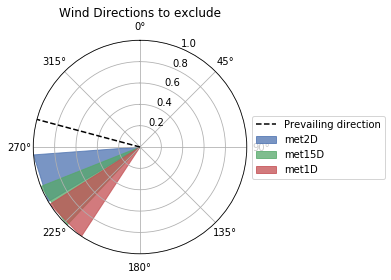

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2.0)

for ii, k in enumerate(keys):
    
    sec = ax.axvspan(np.radians(excluded_angles[k][0]), 
                     np.radians(excluded_angles[k][1]), 
                     alpha=0.75, 
                     color='C{}'.format(ii), 
                     label=k,
                    )
    
ax.axvline(np.radians(285), ls='--', c='k', label='Prevailing direction')
ax.legend(loc=6, bbox_to_anchor=(1,0.5))
ax.set_title('Wind Directions to exclude',va='bottom', pad=10)

plt.tight_layout()